# Imports and package set-up

In [20]:
COLAB = 'google.colab' in str(get_ipython())
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/',)
    %cd /content/drive/MyDrive/Thesis/

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import tensorflow as tf

from hyperopt import fmin, tpe, hp, Trials
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.layers import Dense, Dropout

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # should shut TF up a bit
sns.set()
np.set_printoptions(threshold=256)
rc = {
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "figure.dpi": 100,
    "figure.figsize": [9, 5],
    "font.serif": ["Charter"] + plt.rcParams["font.serif"],
    # 'text.usetex': True,
    # 'text.latex.preamble': [r'\usepackage{amsmath}']
}
plt.rcParams.update(rc)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Thesis


# Simulate

In [46]:
class SimulateData(object):
    def __init__(self, situation, n, one_hot=True, seed=None, equi_distant=False):
        self.situation = situation
        self.n = n
        if seed is not None: np.random.seed(seed)
        
        self.X, self.funcs = self.situational_stuff(equi_distant)
        self.d = 1 if self.X[0].ndim == 0 else self.X[0].shape
        self.K = len(self.funcs)
        
        self.f_X = np.array([f(self.X) for f in self.funcs]).T
        self.Y_prob = np.array([self.f_X[i] / x_sum for i, x_sum in enumerate(self.f_X.sum(axis=1))])
        
        if one_hot: self.Y_one_hot = self.one_hot_from_Y_probs()
        
    def unif_rejection_sampling(self, p):
        # Rejection sampling from density function p; proposal is unif[0, 1].
        # MAYDO: faster sampling method.
        q_pdf = ss.uniform().pdf
        q_sample = np.random.uniform
    
        grid = np.linspace(0, 1, 1000)
        m = max(p(grid)) * 1.3  # should divide by q_pdf(grid) but that's always 1.
        # The 1.3 factor is just to be sure m * q > p. Proportion accepted ~ 1/m.
    
        X = []
        while len(X) < self.n:
            z = q_sample()
            if np.random.uniform(0, m * q_pdf(z)) <= p(z):
                X.append(z)
        return np.array(X)
    
    def situational_stuff(self, equi_distant):
        # Default:
        X = np.random.uniform(size=self.n) if not equi_distant else np.linspace(0, 1, self.n)
        
        if self.situation == "Simple 1D":
            def f1(X): return (1 + X) / 3
            def f2(X): return (2 - X) / 3
            return X, [f1, f2] 
        
        if situation == "Simple 2D":
            # desc = f"Situation 2: sampling {n} X_i ~ 2D uniforms. f1(X) = sum(X) / 2. K = 2."
            X1 = np.random.uniform(size=self.n)
            X2 = np.random.uniform(size=self.n)
            X = np.column_stack([X1, X2])
            def f1(X): return (X[:, 0] + X[:, 1]) / 2
            def f2(X): return 1 - f1(X)
            return X, [f1, f2]
        
        if "x^" in self.situation:
            r_str = situation.split('^')[1].split(' ')[0]
            r = int(r_str) if r_str.isdigit() else 5
            
            # Allow doing something linear after specified b, default to 1
            b_str = situation.split('b=')[1].split(' ')[0] if "b=" in self.situation else "not a valid float"
            b = float(b_str) if b_str[0] in ["0", "."] else 1
            br = b ** r
            def f1(X): return np.array([br + X_i - b if X_i > b else X_i ** r for X_i in X])
            def f2(X): return br + 1 - b - f1(X)
            return X, [f1, f2]
        
        if self.situation == "Mixture of uniforms":
            # TODO: parametrize in that string.
            a = [0.05, .55]
            b = [.45, .95]
            pY = [.5,.5]
    
            def p(x):
                return sum([ss.uniform(a[i], b[i]).pdf(x) * pY[i] for i in range(len(pY))])
    
            X = self.unif_rejection_sampling(p)
            def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * 3))
            def f2(X): return 1 - f1(X)
            return X, [f1, f2]   
        
        if "sin(" in self.situation:
            more = situation.split('+1')
            minimum = float(more[1]) if len(more) > 1 else 0
            def f1(X): return np.sin(2 * np.math.pi * X) + 1 + minimum
            # Or Taylor approximation
            # if "Taylor" in self.situation:
            #     def f1(X, m = 10):
            #         Xp = 2 * np.math.pi * X
            #         return 1 + sum([(-1) ** (i+1) * Xp ** (2*i-1) / np.math.factorial(2*i-1) for i in range(1, m)])
            def f2(X): return 2 + 2 * minimum - f1(X)
            return X, [f1, f2]

        if "sigmoid" in self.situation:
            beta = 4
            def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * beta))
            def f2(X): return 1 - f1(X)
            return X, [f1, f2]
        
        else:
            raise ValueError("Situation not implemented.")
    
    def one_hot_from_Y_probs(self):
        # Assign sample to category with a categorical probability.
        Y_cat = np.array([np.random.choice(self.K, 1, p=p) for p in self.Y_prob])
        return np.eye(self.K)[Y_cat.reshape(-1,)]
        
    def visualize(self):
        # TODO: savefig
        print("Euclidean distance between non- and normalized:", np.linalg.norm(self.f_X - self.Y_prob))

        t_space = np.geomspace(1e-20, 1, 10_000)  # denser where small.
        p_X_smaller = [np.mean(self.Y_prob <= t) for t in t_space]

        if self.X.ndim > 2:
            print("$\mathbf{X}$ dimensionality too high to visualize.")
            return -1
        
        plt.figure(); plt.xlabel("$x$"); plt.ylim(0, 1.05)
        if self.X.ndim == 1:
            plt.plot(t_space, p_X_smaller, color='red', label='$\mathrm{\mathbb{P}}(\mathbf{p}(X) \leq x)$')
            plt.plot(t_space, t_space, '--', alpha=.3, color='red')
            x, _, p = plt.hist(self.X, bins=30, density=True, alpha=.3, label='Scaled density of $X$')
            # Histogram scaling:
            for item in p: item.set_height(item.get_height() / max(x))
            
            # Empirical function plotting:
            order = np.argsort(self.X)
            for i in range(self.Y_prob.shape[1]):
                plt.plot(self.X[order], self.Y_prob[order, i], label=f'Normalized $p^0_{i+1}(x)$')
    
            plt.legend(); plt.show()
        elif self.X.ndim == 2:
            plt.plot(t_space, p_X_smaller, color='red', label='$\mathrm{\mathbb{P}}(\mathbf{p}(\mathbf{X}) \leq x)$')
            x, _, p = plt.hist(self.X, bins=30, density=True, alpha=.3,
                               label=[f'Scaled density of $X_{j+1}$' for j in range(self.X.shape[1])])
            for j in range(self.X.ndim):
                for item in p[j]:
                    item.set_height(item.get_height() / max(x[j]))
            
            plt.legend(); plt.show()

            # New 3D plot:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
    
            subset = np.random.choice(self.X.shape[0], 200)
            for i in range(self.Y_prob.shape[1]):
                ax.scatter(self.X[subset, 0], self.X[subset, 1], self.Y_prob[subset, i],
                           label=f'$p^0_{i+1}(\mathbf{{x}})$')
            ax.set_xlabel('$x_1$')
            ax.set_ylabel('$x_2$')
            ax.legend()
            plt.show()

Euclidean distance between non- and normalized: 273.992628837163


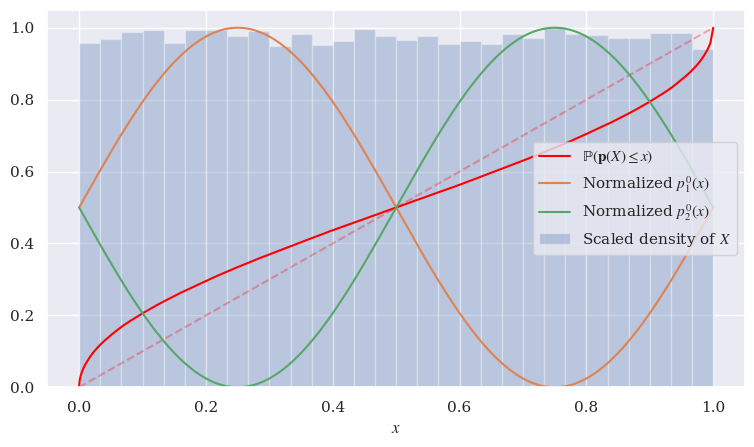

In [22]:
situation = "sin(2*pi*x)+1"
test = SimulateData(situation, 10**5)
test.visualize()

# Network stuff

In [45]:
class KerasModelStuff(object):
    def __init__(self, train, val, hidden_widths=[16, 16, 16, 16], drop=0, l1=.0005):
        self.train = train
        self.val = val

        if self.train.X.ndim == 1:
            self.train.X = self.train.X.reshape(-1, 1)
            self.val.X = self.val.X.reshape(-1, 1)
            # This may have downsides later on

        self.model = self.initialize_model(hidden_widths, drop, l1)

    def initialize_model(self, hidden_widths, drop, l1):
        # ReLU activations for hidden layer, softmax for final.
        # Force _some_ sparsity through dropout and penalizing weights with L1.
        # Note: not the same as theory yet, that has normalization and probably
        #       requires some special strategies for _real_ sparsity.
        # Also NB: I set top drop=0 now.

        m = [self.train.X.reshape(-1, 1)[0].shape, *hidden_widths, self.train.K]
        L = len(hidden_widths)
        model = tf.keras.models.Sequential(name=f'L-is-{L}-and-p_0-is-{m[0][0]}...')

        model.add(Dense(m[1], input_shape=m[0], name=f'p_0->p_1',
                            kernel_regularizer=regularizers.l1(l1)))
        for i in range(2, len(m) - 1):
            model.add(Dropout(drop))
            model.add(Dense(m[i], activation='relu', name=f'p_{i-1}->p_{i}',
                            kernel_regularizer=regularizers.l1(l1)))

        model.add(Dropout(drop))
        model.add(Dense(m[-1], activation='softmax', name=f'p_{L}->p_{L+1}',
                        kernel_regularizer=regularizers.l1(l1)))
        return model
    
    def train_network(self, opt='adam', stop=.0001, viz=0):
        if viz > 1:
            print(self.model.summary())

        self.model.compile(opt, 'categorical_crossentropy')
        # TODO: still playing with magic numbers below
        cb = [tf.keras.callbacks.EarlyStopping('loss', min_delta=stop, patience=25, 
                                               verbose=viz, restore_best_weights=True)]
        history = self.model.fit(self.train.X, self.train.Y_one_hot, epochs=100, callbacks=cb,
                                 validation_data=(self.val.X, self.val.Y_one_hot),
                                 batch_size=32, use_multiprocessing=True, verbose=0)

        if viz > 0:
            pd.DataFrame(history.history).plot()
            plt.gca().set_ylim(
                0, max(1, np.quantile(history.history['val_loss'], .98)))
            plt.grid(True)
            plt.xlabel('Epoch')
            plt.show()

    def KL_trunc_loss(self, true, pred, B, minimum=1e-4):
        # Ugly and slow to make it transparent, bc I'm not sure.
        divergences = []
        for i, true_vec_i in enumerate(true):
            pred_vec_i = pred[i]
            current_sum = 0
            for k, true_i_k in enumerate(true_vec_i):
                pred_i_k = pred_vec_i[k]
                if pred_i_k < minimum:
                    current_sum += true_i_k * B
                else:
                    current_sum += true_i_k * np.minimum(B, np.log(true_i_k / pred_i_k))
            divergences.append(current_sum)
        return np.mean(divergences)

    def get_sparsity(self, epsilon=0.001):
        W = self.model.get_weights()
        nz_biases = biases = nz_weights = weights = 0
        for i, W_i in enumerate(W):
            if i % 2 == 0:
                nz_weights += np.count_nonzero(W_i > epsilon)
                weights += W_i.size
            else:
                nz_biases += np.count_nonzero(W_i > epsilon)
                biases += W_i.size
        return {
            "Biases > e. ": nz_biases, "Total biases": biases,
            "Weights > e.": nz_weights, "Tot. weights": weights,
            "Epsilon     ": epsilon, "s           ": nz_biases + nz_weights
        }

    def evaluate(self, test, B=1.5, visualize=True, loss_only=False):
        p = self.model.predict(test.X)
        t = test.Y_prob
        
        if visualize:
            if self.train.d == 1:
                plt.figure(); plt.xlabel("$x$"); plt.ylim(0, 1.05)
                x, _, items = plt.hist(self.train.X, bins=30, density=True, alpha=.3, 
                                    label='Scaled density of $X$ (train)')
                # Histogram scaling:
                for item in items:
                    item.set_height(item.get_height() / max(x))
                order = np.argsort(test.X)
                for k in range(self.train.K):
                    plt.plot(test.X[order], p[order, k], '--', label=f'$\hat{{p}}_{k+1}(x)$')
                    plt.plot(test.X[order], test.Y_prob[order, k], 
                            label=f'$p^0_{k+1}(x)$', color=plt.gca().lines[-1].get_color())
                plt.xlabel('x')
                plt.legend()
                plt.show()
            # TODO: insert 2D here (I have it somewhere below)
            else:
                print("$\mathbf{X}$ dimensionality too high to visualize.")

        
        losses = {
            "LL": tf.keras.losses.categorical_crossentropy(t, p).numpy().mean(),
            "MSE": tf.keras.losses.MeanSquaredError()(t, p).numpy(),
            "KL": tf.keras.losses.KLDivergence()(t, p).numpy().mean(),
            f"KL_B={B}": self.KL_trunc_loss(t, p, B)
        }
        if loss_only:
            return losses
        else:
            return {
                **losses,
                **self.get_sparsity(),
                "Pr. max difference": np.amax(np.abs(t - p))
            }

In [33]:
def opt_network(situation, n, viz=1, evals=42, stop=.0001, n_repeats=2):
    param_space = {}
    param_space['L'] = 2 + hp.randint('L-2', int(np.log(n) * 1.2))  # a bit ugly but just hyperopt...
    param_space['w'] = 8 + hp.randint('w-8', np.min([56, np.max([8, int(.05 * n)])]))
    param_space['lr'] = hp.uniform('lr', 0.0001, 0.0015)
    param_space['l1'] = hp.uniform('l1', 0.0001, 0.02)
    param_space['drop'] = hp.uniform('drop', 0, 0.2)
    print(f"Searching for optimal {param_space.keys()} in {evals} attempts.")
    print(f"We're in situation {situation} with {n} samples.")

    def obj(params):
        hw = [params['w'] for _ in range(params['L'])]
        opt = optimizers.Adam(params['lr'])

        # TODO?: average over 2 sets per parameter set
        KLs = []
        for _ in range(n_repeats):
            train = SimulateData(situation, n)  # there's no default seed
            val = SimulateData(situation, 10**4)
            kn = KerasModelStuff(train, val, hidden_widths=hw, drop=params['drop'], l1=params['l1'])
            kn.train_network(opt=opt, stop=stop, viz=viz)
            losses = kn.evaluate(val, visualize=viz, loss_only=True)
            KLs.append(losses['KL'])
            if viz > 0:
                print(f"KL {losses['KL']:.4f} and MSE {losses['MSE']:.4f} with parameters {params}")
        return np.mean(KLs)

    filename = f"./hyperopt/{situation}__{n}.hyperopt"
    try: 
        trials = pickle.load(open(filename, "rb"))
        if evals <= len(trials.trials):
            trials.vals
            losses = np.asarray(trials.losses(), dtype=float)
            best_i = np.argmin(losses)
            best_params = {key: values[best_i] for key, values in trials.vals.items()}
            print("Already did", len(trials.trials), ">", evals, "trials, returning", 
                  best_params, "and trials that obtained KL", losses[best_i])
            return best_params, trials
        print(f"Found {len(trials.trials)} trials, so doing {evals - len(trials.trials)}.")
    except:
        if evals == 0:
            raise ValueError(f'evals == 0 and no {filename} found.')
        print(f"{filename} not found, starting trials from scratch.")
        trials = Trials()

    tpe_best = fmin(fn=obj, space=param_space, algo=tpe.suggest, max_evals=evals, trials=trials)
    with open(filename, "wb") as f:
        pickle.dump(trials, f)

    return tpe_best, trials

def evaluate_params(situation, n, test, n_repeats=2, opt_evals=1, params=None, viz=0):
    assert test.situation == situation
    if params is None:
        params, _ = opt_network(situation, n, viz=viz, evals=opt_evals, n_repeats=n_repeats) 
    print("\nEvaluating on test with parameters", params)
    hw = [params['w-8'] + 8 for _ in range(params['L-2'] + 2)]
    opt = optimizers.Adam(params['lr'])

    for i in range(n_repeats):
        print(f"**Iter. {i + 1} of {n} training samples in situation {situation}.**")
        train = SimulateData(situation, n)
        val = SimulateData(situation, 10**4)
        kms = KerasModelStuff(train, val, hidden_widths=hw, drop=params['drop'], l1=params['l1'])
        kms.train_network(opt=opt)
        results = kms.evaluate(test)
        print(f"KL: {results['KL']:.5f}, MSE: {results['MSE']:.5f}")
        # TODO: that quantile stuff from the old .py

Searching for optimal dict_keys(['L', 'w', 'lr', 'l1', 'drop']) in 100 attempts.
We're in situation sin(2*pi*x)+1 with 512 samples.
Found 25 trials, so doing 75.
100%|██████████| 75/75 [37:45<00:00, 30.21s/it, best loss: 0.01993374526500702]

Evaluating on test with parameters {'L-2': 4, 'drop': 0.037043460889982095, 'l1': 0.0001983847672859415, 'lr': 0.0014917631117716465, 'w-8': 23}
**Iter. 1 of 512 training samples in situation sin(2*pi*x)+1.**


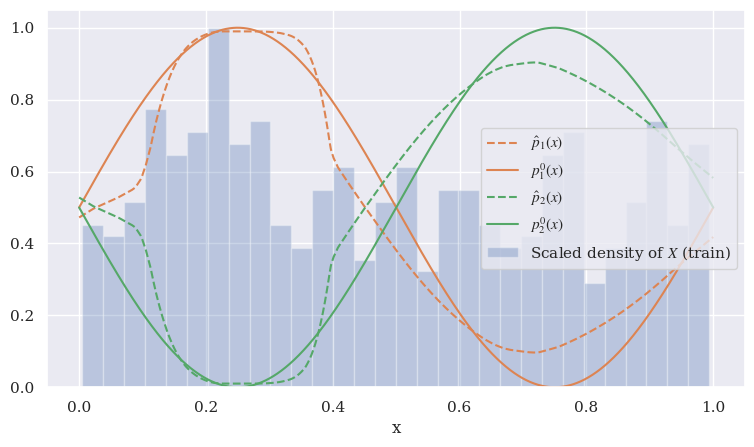

KL: 0.02976, MSE: 0.00844
**Iter. 2 of 512 training samples in situation sin(2*pi*x)+1.**


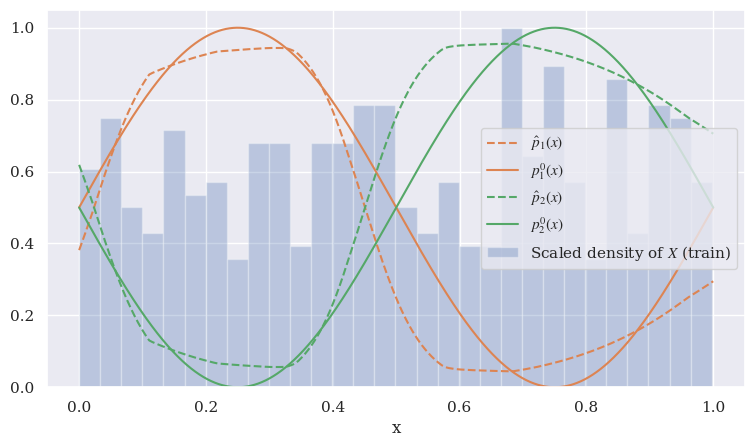

KL: 0.04551, MSE: 0.01162


In [27]:
evaluate_params(situation, 512, test, n_repeats=2, opt_evals=100)

Searching for optimal dict_keys(['L', 'w', 'lr', 'l1', 'drop']) in 50 attempts.
We're in situation sin(2*pi*x)+1 with 2048 samples.
Found 30 trials, so doing 20.
100%|██████████| 20/20 [22:36<00:00, 67.84s/it, best loss: 0.013653985224664211]

Evaluating on test with parameters {'L-2': 6, 'drop': 0.03391362083753734, 'l1': 0.00010334167984074778, 'lr': 0.0007964367348316522, 'w-8': 14}
**Iter. 1 of 2048 training samples in situation sin(2*pi*x)+1.**


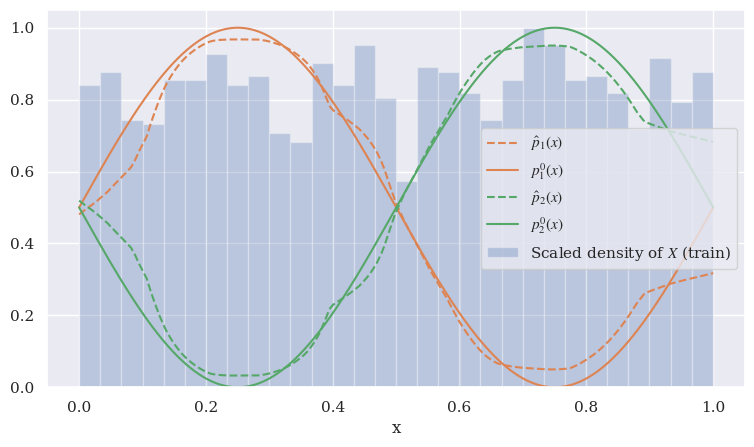

KL: 0.01266, MSE: 0.00297
**Iter. 2 of 2048 training samples in situation sin(2*pi*x)+1.**


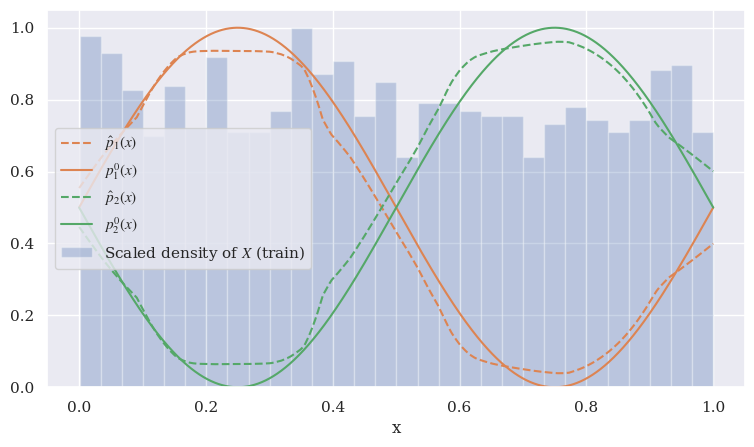

KL: 0.01331, MSE: 0.00245


In [36]:
evaluate_params(situation, 2048, test, n_repeats=2, opt_evals=50)

Searching for optimal dict_keys(['L', 'w', 'lr', 'l1', 'drop']) in 50 attempts.
We're in situation sin(2*pi*x)+1 with 8192 samples.
Found 25 trials, so doing 25.
100%|██████████| 25/25 [38:37<00:00, 92.69s/it, best loss: 0.01581449806690216] 

Evaluating on test with parameters {'L-2': 1, 'drop': 0.10775658399535241, 'l1': 0.0002218025527145643, 'lr': 0.0014946250304031519, 'w-8': 55}
**Iter. 1 of 8192 training samples in situation sin(2*pi*x)+1.**


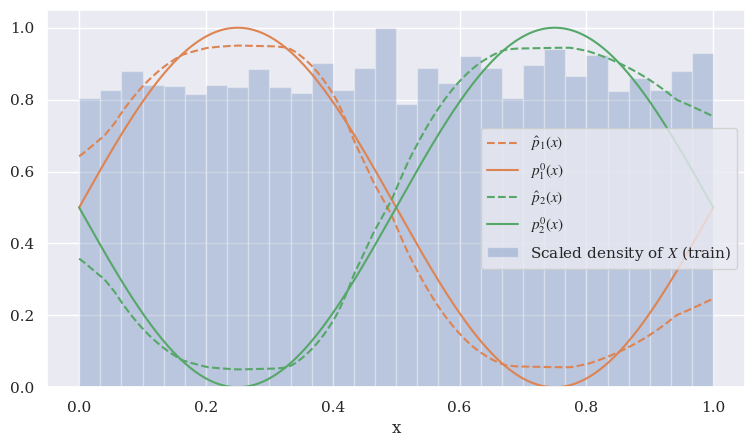

KL: 0.01780, MSE: 0.00439
**Iter. 2 of 8192 training samples in situation sin(2*pi*x)+1.**


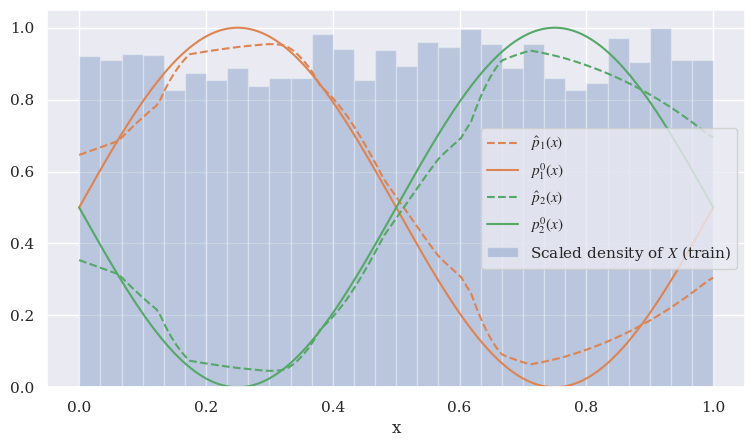

KL: 0.01842, MSE: 0.00380


In [37]:
evaluate_params(situation, 8192, test, n_repeats=2, opt_evals=50)

Euclidean distance between non- and normalized: 363.3243625026428


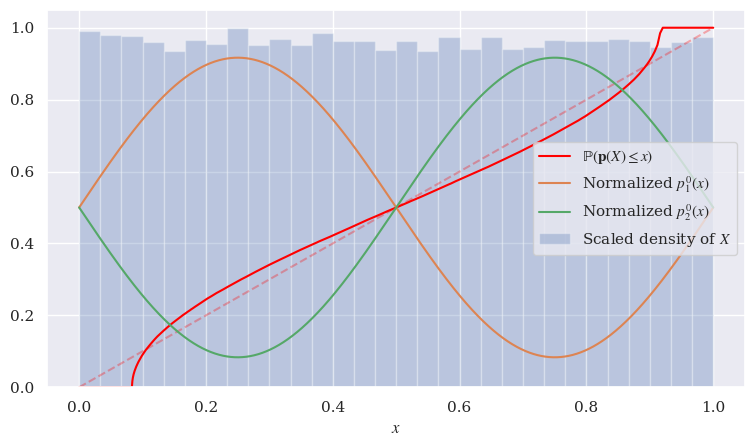

In [47]:
situation = "sin(2*pi*x)+1.2"
test = SimulateData(situation, 10**5)
test.visualize()

In [ ]:
evaluate_params(situation, 512, test, n_repeats=2, opt_evals=50)

Searching for optimal dict_keys(['L', 'w', 'lr', 'l1', 'drop']) in 50 attempts.
We're in situation sin(2*pi*x)+1.2 with 512 samples.
Found 20 trials, so doing 30.
 40%|████      | 12/30 [13:03<19:05, 63.67s/it, best loss: 0.03565569221973419]

Searching for optimal dict_keys(['L', 'w', 'lr', 'l1', 'drop']) in 20 attempts.
We're in situation sin(2*pi*x)+1.2 with 2048 samples.
./hyperopt/sin(2*pi*x)+1.2__2048.hyperopt not found, starting trials from scratch.
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['sin(2*pi*x)', '.2']
0.2
['s

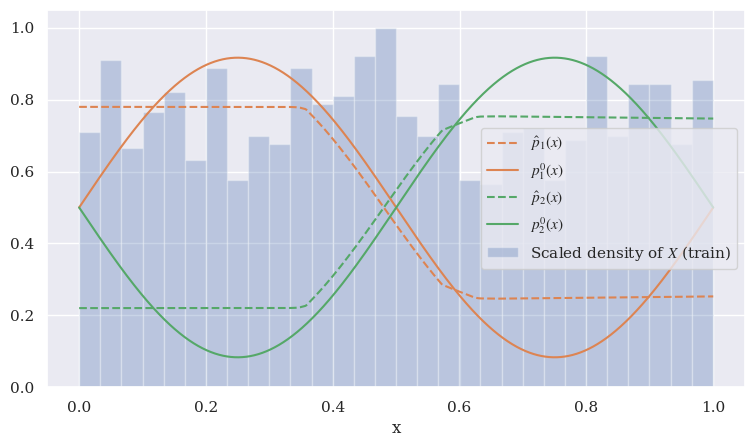

KL: 0.03528, MSE: 0.01210
**Iter. 2 of 2048 training samples in situation sin(2*pi*x)+1.2.**
['sin(2*pi*x)', '.2'] 0.2


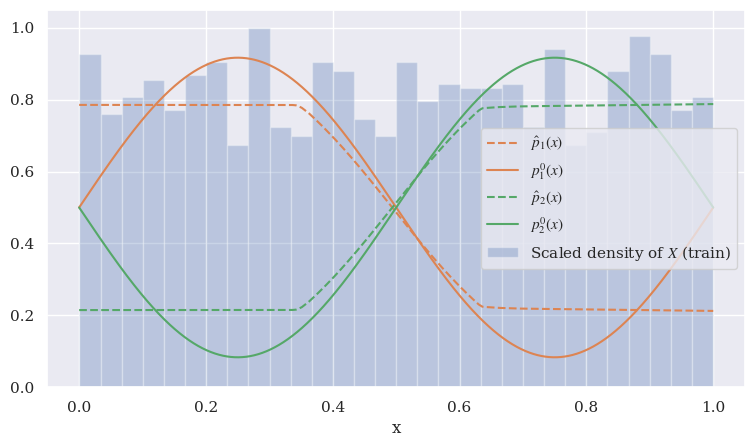

KL: 0.03298, MSE: 0.01121


In [44]:
evaluate_params(situation, 2048, test, n_repeats=2, opt_evals=20)

### Temporarily moved out of the way

In [8]:
In sample_and_funcs:
    
    elif situation == "3":
        desc = f"Situation 3: sampling {n} X_i ~ a mixture of normals. K = 2."
        mu = [.4, .8]
        sigma = [.5, .1]
        pY = [.5, .5]

        def p(x):
            return sum([ss.norm(mu[i], sigma[i]).pdf(x) * pY[i] for i in range(len(mu))])

        X = unif_rejection_sampling(p, n, seed)
        funcs = [ss.norm(mu[i], sigma[i]).pdf for i in range(len(mu))]
    elif situation == "4":
        desc = f"Situation 4: sampling {n} X_i ~ 1D uniform. f1(X)=f2(X). K = 2."
        X = np.random.uniform(size=n)
        def f1(X): return (1 + X) / 3
        def f2(X): return f1(X)
        funcs = [f1, f2]
    elif "6." in situation:
        # TODO: handle above?
        K_str = situation.split('.')[1]
        if K_str != "":
            K = int(K_str)
        else:
            K = 3
            print("K not specified, just setting it to 3.")
        desc = f"Situation 6: sampling {n} X_i ~ 1D uniform. f_k(X) = a normal. K = {K}."
        X = np.random.uniform(size=n)
        funcs = []
        for k in range(K):
            funcs.append(lambda x, k=k: ss.norm(k / K, 0.5 / K).pdf(x))
    elif situation == "7":
        desc = f"Situation 7: sampling {n} X_i ~ 1D uniform. f1(X) = TODO. K = 2."
        X = np.random.uniform(size=n)
        beta = 4
        def f1(X): return 1 / (1 + np.power(X / (1 - X), - 1 * beta))
        def f2(X): return 1 - f1(X)
        funcs = [f1, f2]


In visualize_tf:
    elif X_test.shape[1] == 2:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        n, k = Y_prob_test.shape
        subset = np.random.choice(n, 200)
        step = int(n / 200)
        subset = list(np.argsort(X_test[:, 0]))[::step]
        # MAYDO: seperate plots for both classes
        for i in range(k):
            ax.scatter(X_test[subset, 0], X_test[subset, 1], Y_test_pred[subset, i],
                       label=f'$\hat{{p}}_{i+1}(\mathbf{{x}})$')
            ax.scatter(X_test[subset, 0], X_test[subset, 1], Y_prob_test[subset, i],
                       label=f'$p^0_{i+1}(\mathbf{{x}})$', marker='^')

        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.legend()
        plt.show()
        plt.show()
    else:
        print("Not visualizing since X.ndim > 2")

SyntaxError: ignored